# Group Project Report: 
# Evaluation of K-Nearest Neighbours Classification Prediction on Algerian Forest Fire based on Fine Fuel Moisture Code (FFMC) and Drought Code (DC)
Group members: Cassie Zhong, Khoi Nguyen, Helen He, Donna Li

## Introduction

### Background information: 
While forest fires can be incredibly destructive to the environment, they are also a natural part of forest life cycles. To mitigate risks and better prepare local areas, being able to predict if a forest fire will occur at a given time would be very beneficial. 

Researchers have collected data on forest fires in two regions of Algeria, Bejaia and Sidi Bel-Abbes, from June 2012 to September 2012 (https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++). This dataset includes 244 total observations and 10 variables: 
- Temperature, in Celsius degrees
- Relative humidity, in %
- Wind speed, in km/h
- Rain, in mm
- Fine Fuel Moisture Code (FFMC)
- Duff Moisture Code (DMC)
- Drought Code (DC)
- Initial Spread Index (ISI)
- Buildup Index (BUI)
- Fire Weather Index (FWI)

Six of these variables (FFMC, DMC, DC, ISI, BUI and FWI) are components of the Forest Fire Weather Index System (https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi), indicating relative potential for wildfires, and are calculated from the remaining four variables (temperature, relative humidity, wind speed and rain).

### Figure 1: The Fire Weather Index (FWI) structure
<img src='https://cwfis.cfs.nrcan.gc.ca/images/fwi_structure.gif' width='400'>

Source: https://cwfis.cfs.nrcan.gc.ca/images/fwi_structure.gif

Using this dataset, we will attempt to perform K-nearest neighbours classification to predict from a new set of measurements if a forest fire will occur, and we will evaluate the accuracy of such predictions.

## Question: How accurate is the prediction of whether a fire will occur based on FFMC and DC using knn Classification?


## The big picture:
In order to evaluate the accuracy for our prediction, we have divided the work into two parts: the first part focuses on how the dataset is cleaned up and the second part focused on how the model training and evaluation is performed. By employing cross-validation, we can find the k value with the highest accuracy; then we use knn classification model to make predictions on the testing dataset to evaluate the accuracy.

In [1]:
###
#   Run this cell to install GGally package
###

install.packages("GGally")

Warning message in install.packages("GGally"):
“installation of package ‘GGally’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
###
#   Load necessary packages
###

library(repr)
library(tidyverse)
library(tidymodels)
library(dplyr)
library(tidyr)
library(GGally)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3      ✔ yardstick 0.0.7 

Warning message:
“package ‘broom’ was built und

In [3]:
###
#   Set seed to ensure reproducible results
###

set.seed(9999)

## Part 1: Preliminary exploratory data analysis

In [4]:
###
#   Step 1: Reading the dataset into R
###
dataset_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv"

# Read dataset of Bajaia region and change Classes column type to fct
bajaia_data_all <- read_csv(dataset_url, skip = 1, n_max = 122) %>%
    mutate(Classes = as.factor(Classes))

# Read first 43 rows of dataset of Sidi-Bel Abbes region and change Classes column type to fct
sidi_data_1 <- read_csv(dataset_url, skip = 126, n_max = 43) %>%
    mutate(Classes = as.factor(Classes))

# Read remaining rows of dataset of Sidi-Bel Abbes region and change Classes column type to fct
sidi_data_2_colnames <- colnames(sidi_data_1)
sidi_data_2 <- read_csv(dataset_url, skip = 171, col_names = sidi_data_2_colnames) %>%
    mutate(Classes = as.factor(Classes))

# Concatenate the Sidi-Bel Abbes data frames
sidi_data_all <- rbind(sidi_data_1, sidi_data_2)

# Display raw datasets
 bajaia_data_all %>%
     head(6)
 sidi_data_all %>%
     head(6)

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_double(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_double(),
  Classes = col_character()
)

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_double(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_double(),
  Classes = col_character()
)

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),

day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
01,06,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire
05,06,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire
06,06,2012,31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,fire


day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
01,06,2012,32,71,12,0.7,57.1,2.5,8.2,0.6,2.8,0.2,not fire
02,06,2012,30,73,13,4.0,55.7,2.7,7.8,0.6,2.9,0.2,not fire
03,06,2012,29,80,14,2.0,48.7,2.2,7.6,0.3,2.6,0.1,not fire
04,06,2012,30,64,14,0.0,79.4,5.2,15.4,2.2,5.6,1.0,not fire
05,06,2012,32,60,14,0.2,77.1,6.0,17.6,1.8,6.5,0.9,not fire
06,06,2012,35,54,11,0.1,83.7,8.4,26.3,3.1,9.3,3.1,fire


## Explanation for Step 1
The original dataset messed up with one row (171th row) which was within the Sidi-Bel section of the dataset, so we had to fix this issue before cleaning the data. When we read the dataset into R, we separate the two regions (Bajaia and Sidi-Bel) first, because Bajaia data was not affected and we could directly read Bajaia data into R without any splitting. Then, we discarded the 171th row in the Sidi-Bel data by splitting the it into two parts and then recombined them.

In [14]:
###
#   Step 2: Dataset Cleaning & Wrangling
###

# Bind new Region column to each data frame
bajaia_region <- "Bajaia"
sidi_region <- "Sidi-Bel Abbes"
bajaia_data_all["Region"] <- bajaia_region
sidi_data_all["Region"] <- sidi_region


# Combine Bajaia and Sidi-Bel Abbes data frames
fire_data <- rbind(bajaia_data_all, sidi_data_all)

# Split data into training and testing sets
fire_split <- initial_split(fire_data, prop = 0.75, strata = Classes)
fire_train <- training(fire_split)
fire_test <- testing(fire_split)

## Explanation for Step 2
In this step, we combined the two regions into one entire dataset again, but this time the messed-up row has been discarded. Then we split the dataset into training and testing by a proportion of 75%. We choose this proportion because the entire dataset was not relatively large (with 243 observations), so we would like to increase the accuracy of the model by having more observations in the training dataset.

In [6]:
###
#   Step 3: Summarize data from training dataset
###

# Get number of observations for each Classes in training dataset
fire_train_yes <- fire_train %>%
    filter(Classes == "fire") %>%
    nrow()
fire_train_no <- fire_train %>%
    filter(Classes == "not fire") %>%
    nrow()
observations_per_class <- tibble(classes = c("fire", "not fire"), 
                                 observations = c(fire_train_yes, fire_train_no))
observations_per_class

classes,observations
<chr>,<int>
fire,103
not fire,80


## Explanation for Step 3
We would like to know whether the observations in the training dataset was biased or not (whether there were too many "fire" cases, or too many "not fire" cases) to make sure that the predictions made by the model is not simply "guessing" based on the majority. We counted the number of observations for each outcome, and the number of observations for "fire" and "not fire" is 103 vs 80 respectively, which is close enough.

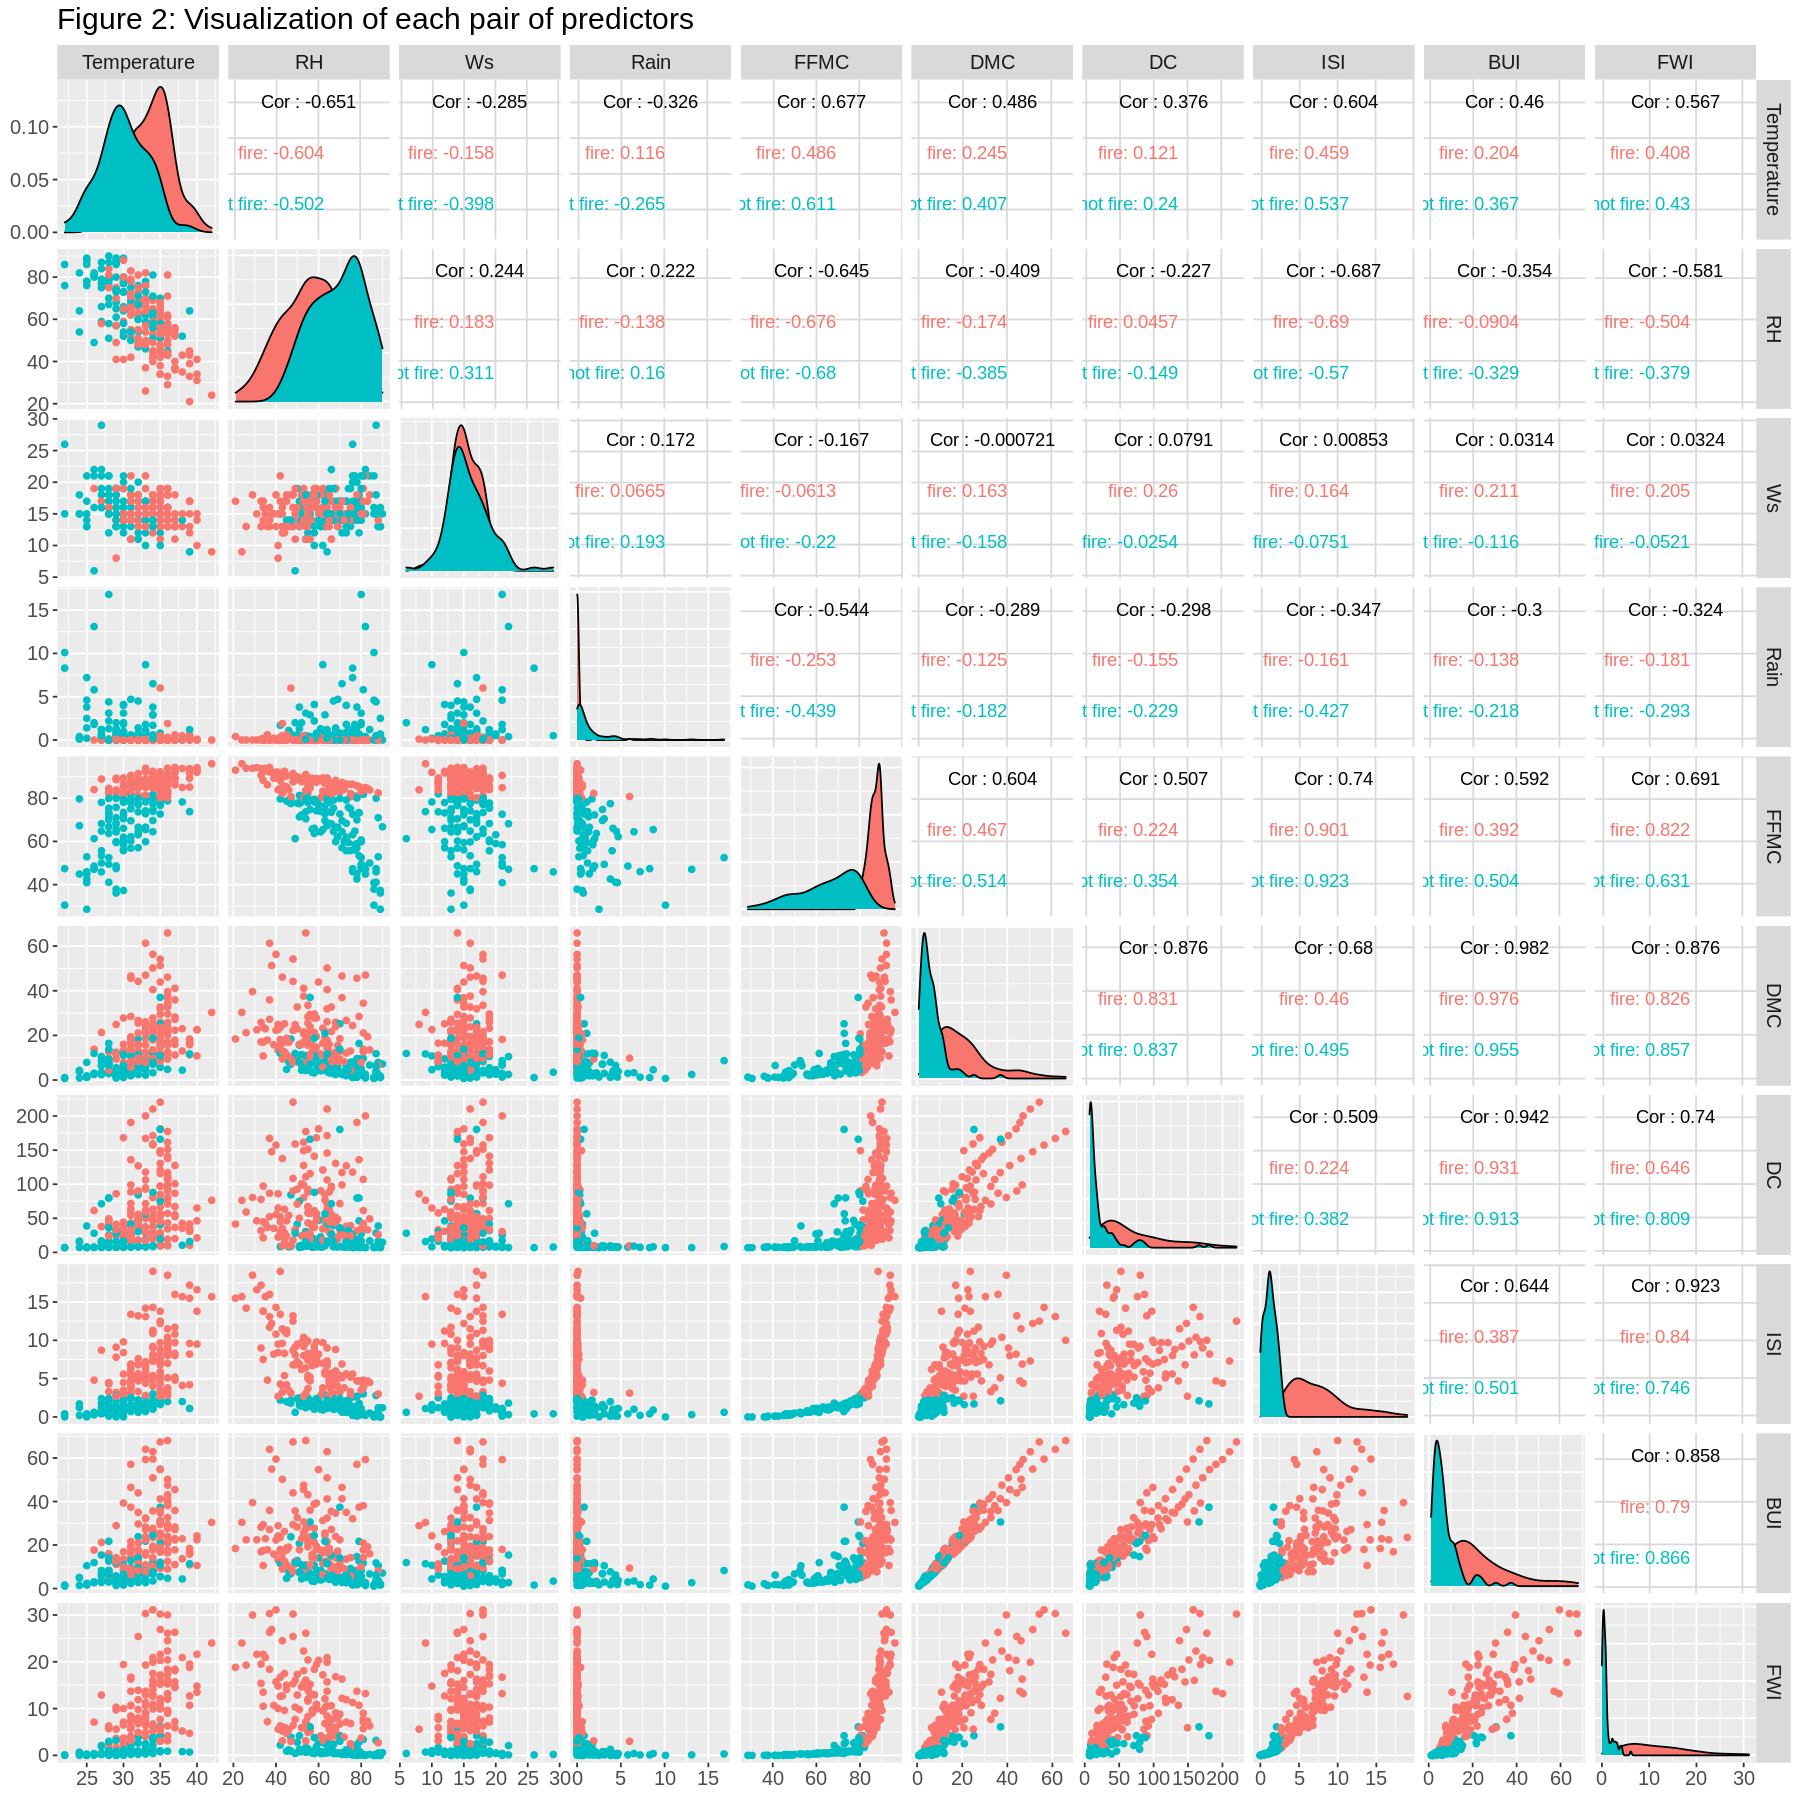

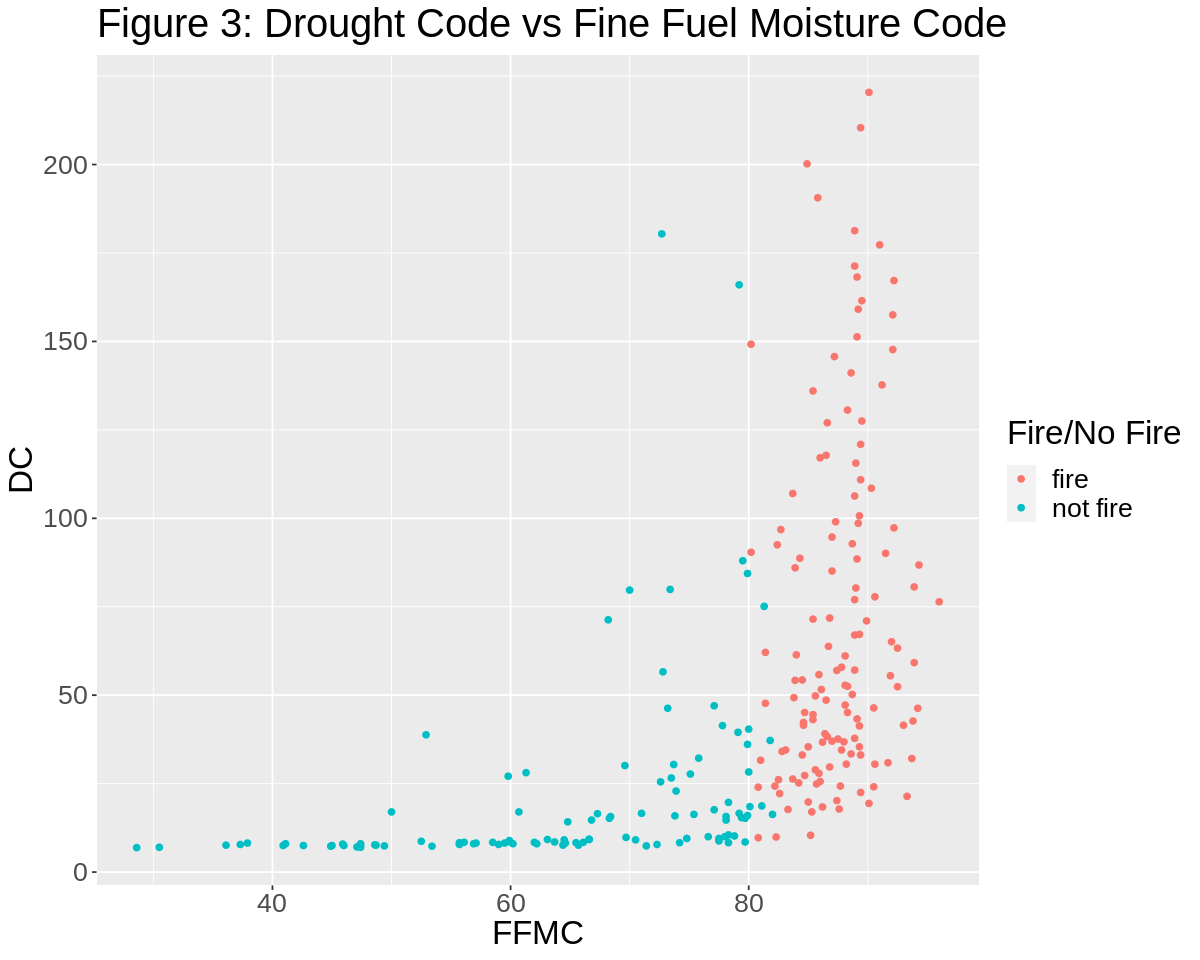

In [15]:
###
#   Step 4: Visualize data from training dataset
###

# Plot each variables against each other
options(repr.plot.height = 15, repr.plot.width = 15)
variables_all_plot <- ggpairs(fire_data, columns = 4:13, aes(color = Classes)) + 
                    ggtitle("Figure 2: Visualization of each pair of predictors") +
                    theme(text = element_text(size = 15))
variables_all_plot

# Create a scatterplot of FFMC vs DC
options(repr.plot.height = 8, repr.plot.width = 10)
ffmc_dc_plot <- ggplot (fire_data, aes(x = FFMC, y = DC, color = Classes)) +
                    geom_point() +
                    labs(x = "FFMC", y = "DC", color = "Fire/No Fire") +
                    ggtitle("Figure 3: Drought Code vs Fine Fuel Moisture Code") +
                    theme(text = element_text(size = 20))
ffmc_dc_plot

## Explanation for Step 4
We choose two predictors, FFMC and DC, out of the ten predictors in the original dataset. This is because we would like to create a simpler visualization of 

## Part 2: Data Analysis

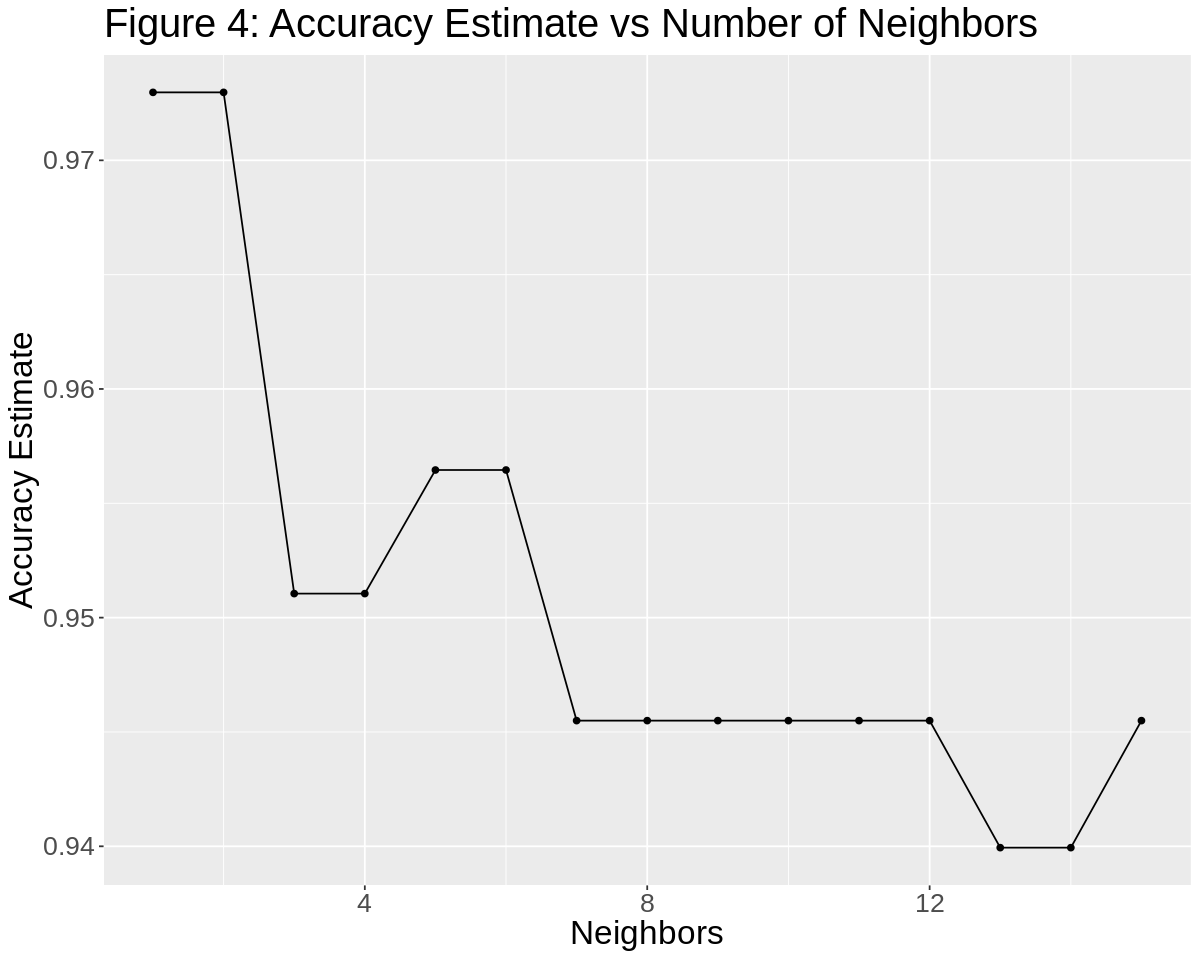

In [16]:
###
#   Cross-validation for K-NN model tuning
###

# Create recipe for data pre-processing from training dataset
fire_recipe <- recipe(Classes ~ FFMC + DC, data = fire_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    prep()

# Create 5 fold splits of training data
fire_vfold <- vfold_cv(fire_train, v = 5, strata = Classes)

# Define K-NN model specification for K tuning
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# Perform cross-validation with 15 values of K
k_vals <- tibble(neighbors = seq(from = 1, to = 15, by = 1))
knn_results_tune <- workflow() %>%
    add_recipe(fire_recipe) %>%
    add_model(knn_spec_tune) %>%
    tune_grid(resamples = fire_vfold, grid = k_vals) %>%
    collect_metrics()
# knn_results_tune

# Plot accuracy vs K 
accuracy_vs_k <- knn_results_tune %>%
    filter(.metric == "accuracy") %>%
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Neighbors", y = "Accuracy Estimate") +
        ggtitle("Figure 4: Accuracy Estimate vs Number of Neighbors") +
        theme(text = element_text(size = 20))
accuracy_vs_k

From this plot, we choose $k = 5$.

In [9]:
###
#   Train K-NN model with K = 5
###

# Re-define K-NN model specification with  K = 5
tuned_k = 5
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tuned_k) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# Train model with training set
fire_knn_fit <- workflow() %>%
    add_recipe(fire_recipe) %>%
    add_model(knn_spec) %>%
    fit(fire_train)
fire_knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~tuned_k,     kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.04371585
Best kernel: rectangular
Best k: 5

In [10]:
###
#   Evaluate accuracy of model
###


# Predict labels in testing set
fire_test_predictions <- predict(fire_knn_fit, fire_test) %>%
    bind_cols(fire_test)

# Report accuracy and confusion matrix of predictions
fire_accuracy <- fire_test_predictions %>%
    metrics(truth = Classes, estimate = .pred_class) %>%
    filter(.metric == "accuracy") %>%
    select(.estimate) %>%
    pull()


fire_conf_mat <- fire_test_predictions %>%
    conf_mat(truth = Classes, estimate = .pred_class)

In [11]:
fire_accuracy

[1] 0.9666667

In [12]:
fire_conf_mat

          Truth
Prediction fire not fire
  fire       33        1
  not fire    1       25

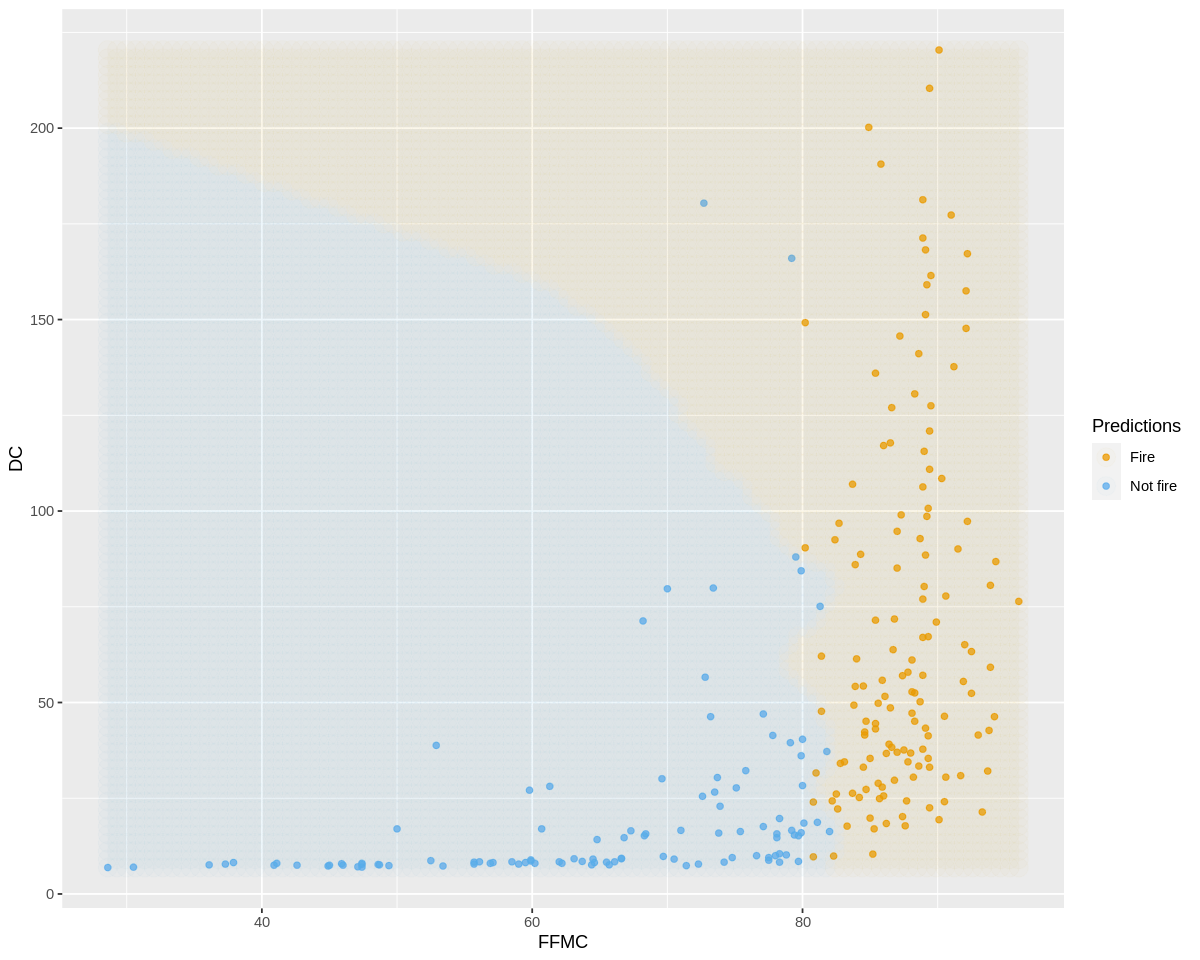

In [20]:
# create the grid of area/smoothness vals, and arrange in a data frame
are_grid <- seq(min(fire_data$FFMC), max(fire_data$FFMC), length.out = 100)
smo_grid <- seq(min(fire_data$DC), max(fire_data$DC), length.out = 100)
asgrid <- as_tibble(expand.grid(FFMC = are_grid, DC = smo_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(fire_knn_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>% rename(Classes = .pred_class)

# plot:
# 1. the coloured scatter of the original data
# 2. the faded coloured scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = fire_data, mapping = aes(x = FFMC, y = DC, color = Classes), alpha = 0.75) +
  geom_point(data = prediction_table, mapping = aes(x = FFMC, y = DC, color = Classes), alpha = 0.02, size = 5.) +
  labs(color = "Predictions") +
  scale_color_manual(labels = c("Fire", "Not fire"), values = c("orange2", "steelblue2"))
wkflw_plot

## Citation 

1. 
Faroudja ABID et al, Algerian Forest Fires Dataset Data Set. UCI machine Learning Repository: Algerian forest Fires dataset data set. (n.d.). Retrieved from https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++. 


2. Canada, N. R. (n.d.). Canadian wildland fire Information System: Canadian forest Fire Weather Index (fwi) system. Canadian Wildland Fire Information System | Canadian Forest Fire Weather Index (FWI) System. Retrieved from https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi. 


